In [7]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy import ndimage

In [13]:
!wget 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'

def load_image(filename, as_gray=False, as_float=False):
    if as_gray:
        a = np.asarray(Image.open(filename).convert('L'))
    else:
        a = np.asarray(Image.open(filename))
    if as_float:
        return a.astype(np.float) / 255
    else:
        return a

def display_image(im, as_gray=False, title=None):
    plt.figure(figsize=(9,4))
    if as_gray:
        plt.imshow(im, cmap='gray')
    else:
        plt.imshow(im)
    if title is not None:
        plt.title(title)

def display_vec(v, title=None):
    plt.figure(figsize=(9,4))
    plt.plot(v)
    if title is not None:
        plt.title(title)
        

im = load_image('CircleLineRect.png', as_gray=True, as_float=False)

--2023-10-02 12:43:29--  https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘Lenna_(test_image).png.3’

Lenna_(test_image). 100%[===================>] 462.73K  --.-KB/s    in 0.04s   

2023-10-02 12:43:30 (12.2 MB/s) - ‘Lenna_(test_image).png.3’ saved [473831/473831]



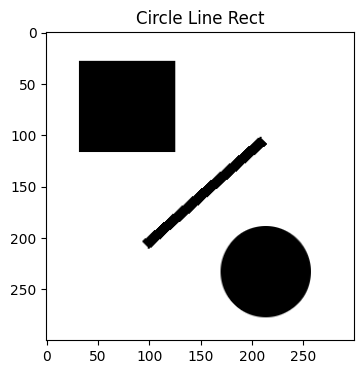

In [15]:
display_image(im=im, as_gray=True, title='Circle Line Rect')

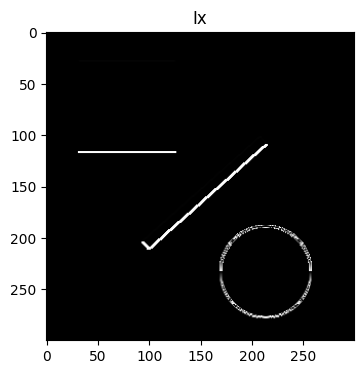

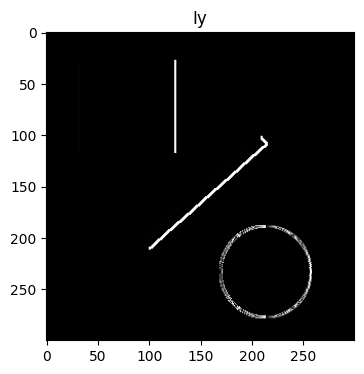

In [18]:
#Both partial derivatives


#Give me the partial derivatives of the image Ix, Iy and Ixy

# TODO
Ix = ndimage.sobel(im, axis=0)
Iy = ndimage.sobel(im, axis=1)


display_image(Ix, as_gray=True, title='Ix')
display_image(Iy, as_gray=True, title='Iy')



